# Credit Card Fraud Detection
Credit card fraud is one of the most significant challenges facing the financial industry today with losses in the UK amounting to **£551.3 million in 2023 alone**! Fraudulent transactions are rare but highly impactful, making them extremely difficult to detect.

From a machine learning perspective, this presents a **highly imbalanced classification problem**:
- The vast majority of transactions are legitimate.
- Fraudulent transactions make up a very small fraction (**<0.2% in the dataset to be used**).
- A naive model that predicts “not fraud” for everything would achieve 99%+ accuracy, but it would **completely fail at its actual purpose** — detecting fraud.

This project aims to build and evaluate machine learning models that can detect fraudulent transactions with **high recall** (catch as many frauds as possible) while maintaining **precision** (limiting false alarms).

To achieve this, I implemented:
- **Supervised Learning Models** (Logistic Regression, Random Forest, XGBoost) to learn from labelled fraud cases.
- **Anomaly Detection Approaches** (Isolation Forest, Autoencoders) to detect unusual patterns without labels.
- **Cost-Sensitive Learning** to penalise false negatives more heavily, since missing a fraud case is much more costly than flagging a legitimate transaction.

The key business problem:
**How can we detect fraudulent transactions effectively in real-time without overwhelming investigators with too many false positives?**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


***
## Library Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

***
## Data Loading & Initial Exploration 

In [3]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


28 of the 31 columns have been anonymised for confidentiality. The remaining 3 columns include:
- `Time`: number of seconds elapsed between each transaction and the first transaction in the dataset.
- `Amount`: quantity of the transaction.
- `Class`: our target variable representing whether the transaction is fraudulent (1) or genuine (0).




In [4]:
df.dtypes.value_counts()

float64    30
int64       1
Name: count, dtype: int64

The target variable `Class` can only take the binary values 1 and 0 making it a categorical variable. All 30 features are numerical so categorical encoding won't be required.

In [5]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

No missing values so imputation won't be required either.

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.369007e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.500885e-15,-5.620335e-16,1.149614e-16,-2.426963e-15,...,1.596686e-16,-3.576577e-16,2.650499e-16,4.472317e-15,5.109395e-16,1.686100e-15,-3.662399e-16,-1.225457e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Here are some observations I made from the table above and the conclusions I came to as a result:

- `Class` mean is **0.001727** → dataset is very imbalanced (only ~0.17% of transactions are fraudulent) → must handle with resampling (**SMOTE/undersampling**) or **cost-sensitive learning**.  
- Consequently, confusion matrix accuracy won't be a reliable metric → better to use **precision, recall, F1-score and AUC**.  

- `Amount` median is **22** & 75% of transactions are **<77** → most purchases are small → fraudsters often test cards with small amounts before large transactions, so **distribution of fraud vs. non-fraud by amount** is worth investigating.  

- The PCA-transformed features have a mean ≈ 0 due to PCA standardisation but their ranges vary significantly → some components capture extreme variations → non-linear models like **XGBoost** will be able to capture relationships better.  

- Some extreme values in PCA features (e.g., **V3, V25**) might be **outliers** worth handling.  
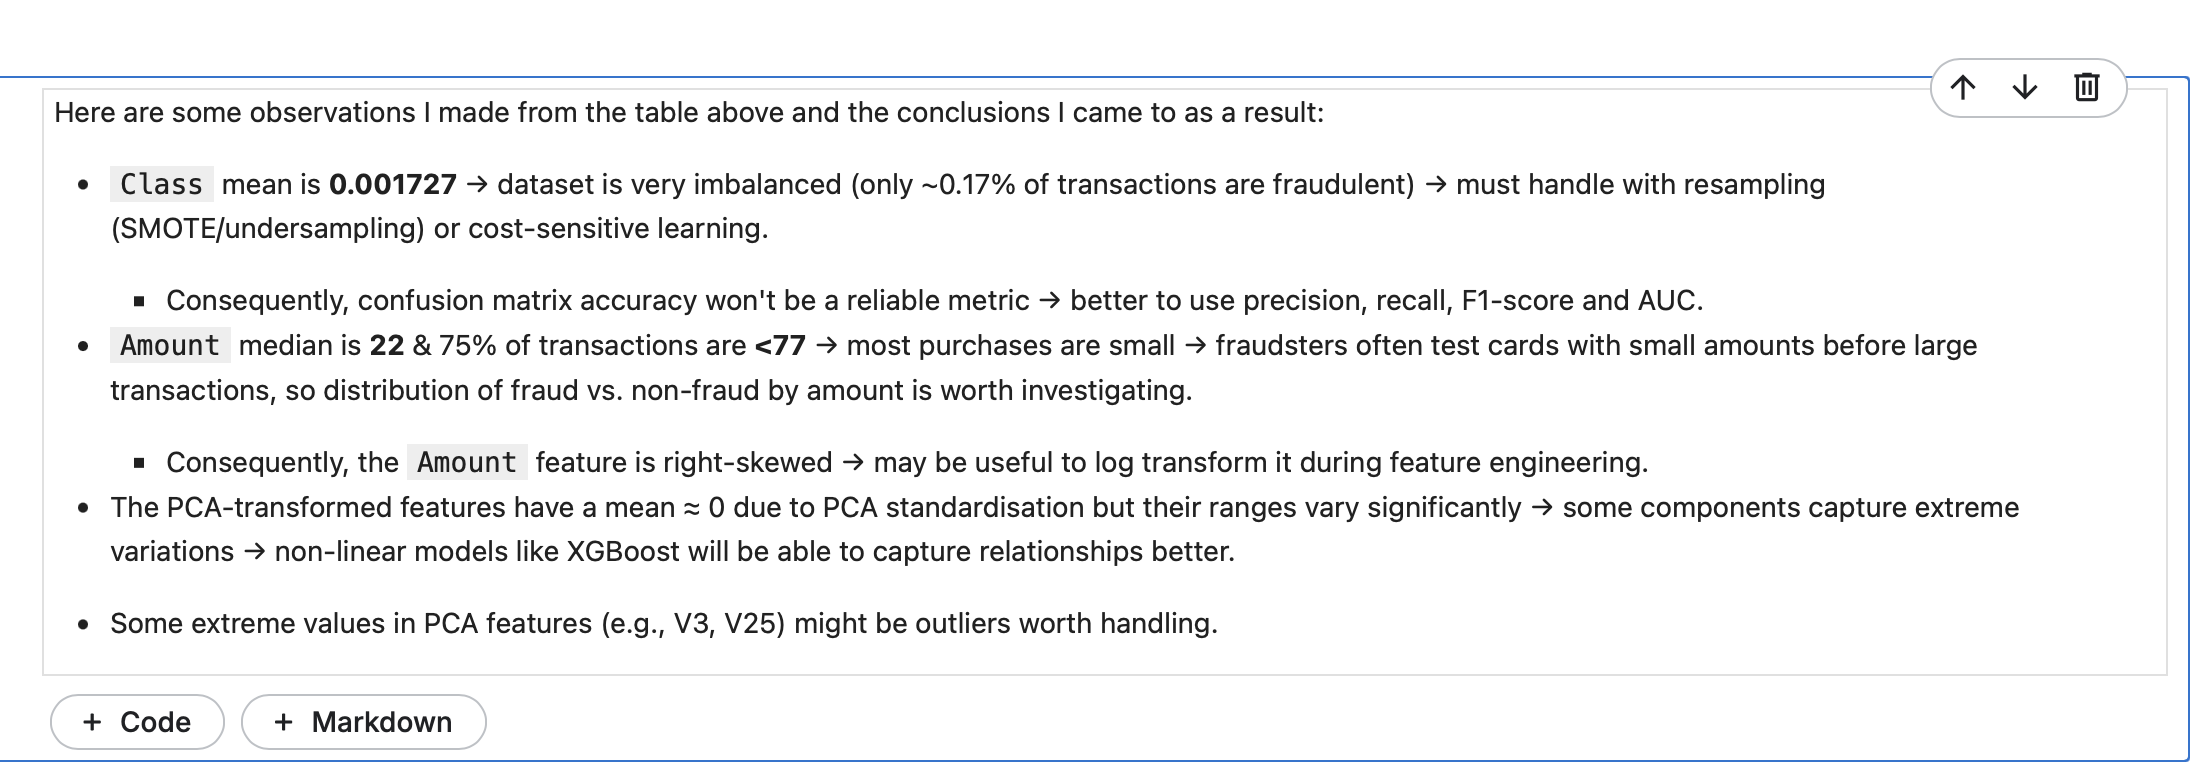

***
## Exploratory Data Analysis (continued)

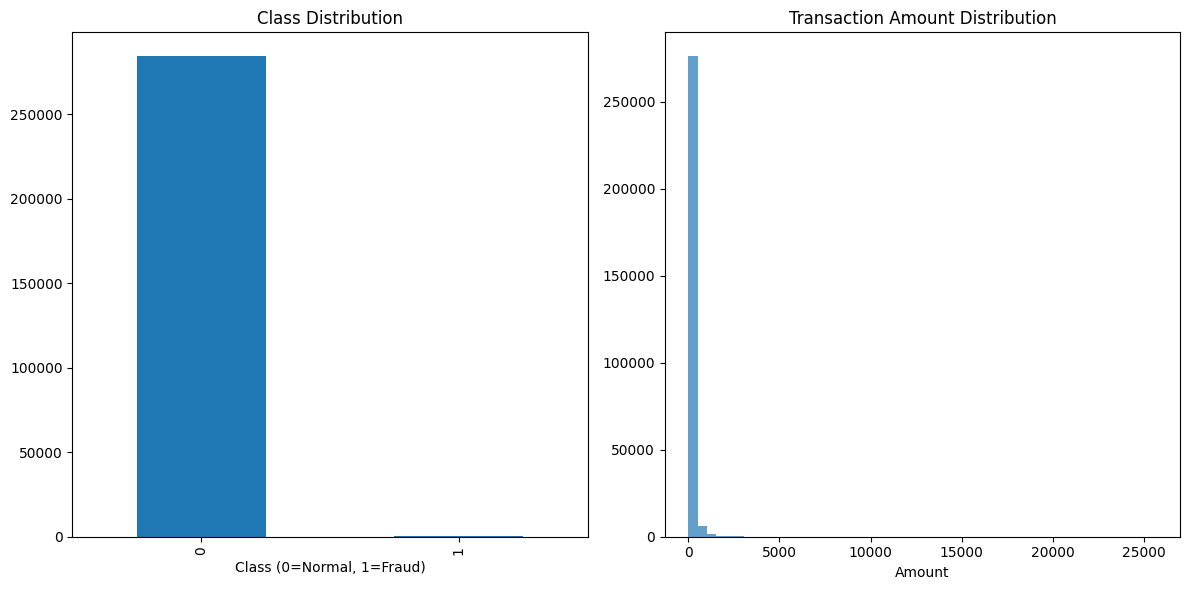

In [15]:
# Class Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['Class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class (0=Normal, 1=Fraud)')


# Transaction Amount Distribution
plt.subplot(1, 2, 2)
plt.hist(df['Amount'], bins=50, alpha=0.7)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.tight_layout()
plt.show()

- Left plot reinforces our findings from the earlier .describe() output; the bar for fraudulent transactions is barely visible.
- Right plot shows that the `Amount` feature is right-skewed → may be useful to **log transform** it during feature engineering to reduce skewness & stabilise variance → makes models more robust.
- Next, I should investigate the distribution of `Amount` for fraud vs non-fraud classes in order to reveal further important patterns.


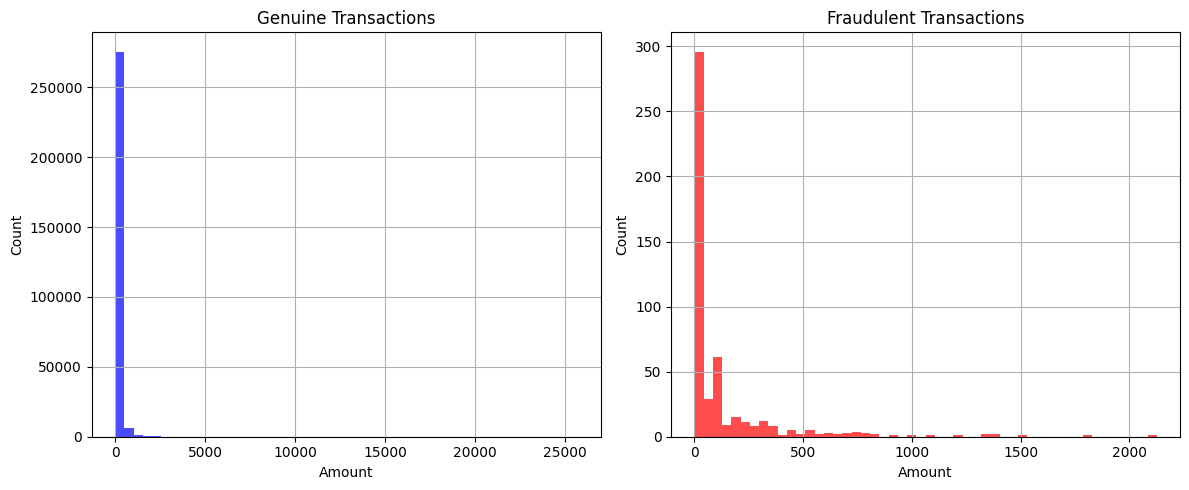

In [14]:
plt.figure(figsize=(12, 5))

# Genuine transactions
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
df[df['Class'] == 0]['Amount'].hist(bins=50, alpha=0.7, color='blue')
plt.title('Genuine Transactions')
plt.xlabel('Amount')
plt.ylabel('Count')

# Fraud transactions
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
df[df['Class'] == 1]['Amount'].hist(bins=50, alpha=0.7, color='red')
plt.title('Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

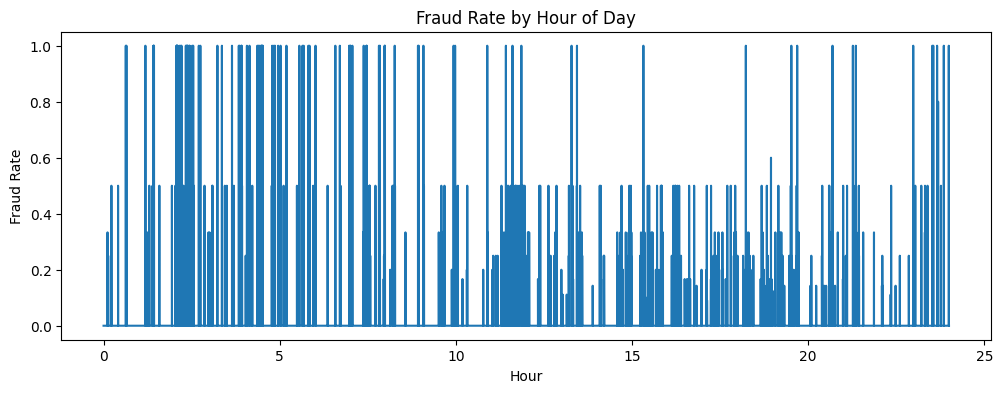

In [16]:
# Time Pattern Analysis
df['Hour'] = (df['Time'] / 3600) % 24
fraud_by_hour = df.groupby(['Hour', 'Class']).size().unstack(fill_value=0)
fraud_rate_by_hour = fraud_by_hour[1] / (fraud_by_hour[0] + fraud_by_hour[1])

plt.figure(figsize=(12, 4))
plt.plot(fraud_rate_by_hour.index, fraud_rate_by_hour.values)
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate')
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


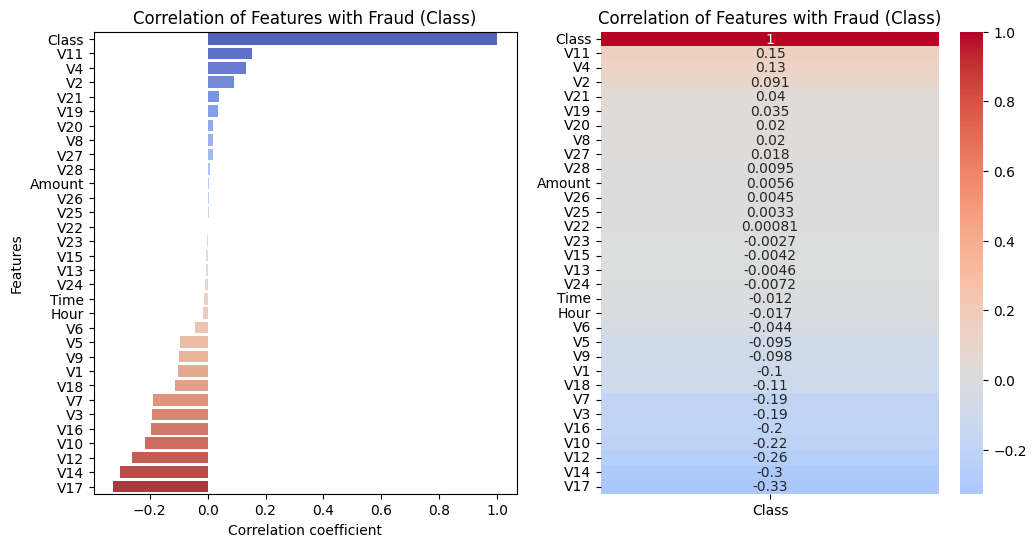

<Figure size 640x480 with 0 Axes>

In [29]:
# Compute correlations with 'Class'
correlations = df.corr()['Class'].sort_values(ascending=False)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.barplot(x=correlations.values, y=correlations.index, palette="coolwarm")
plt.title("Correlation of Features with Fraud (Class)")
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")

plt.subplot(1, 2, 2)
sns.heatmap(corr_with_class, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of Features with Fraud (Class)")

plt.show()
plt.tight_layout()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

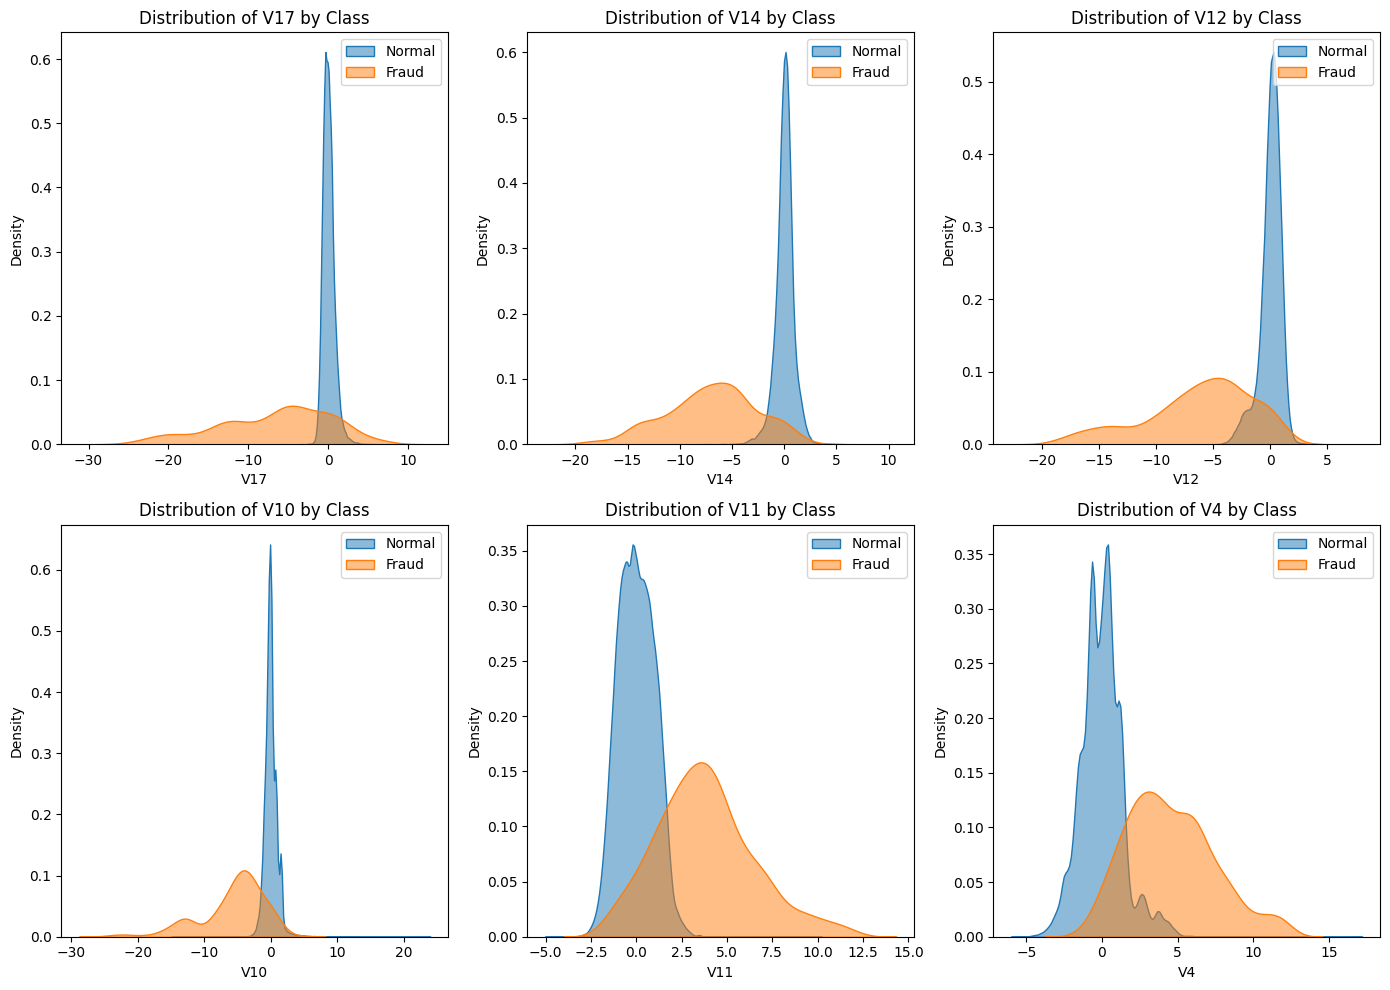

In [30]:
top_features = ['V17', 'V14', 'V12','V10','V11','V4'] #features with strongest absolute correlation

plt.figure(figsize=(14, 10))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=df[df['Class'] == 0], x=feature, label="Normal", fill=True, alpha=0.5)
    sns.kdeplot(data=df[df['Class'] == 1], x=feature, label="Fraud", fill=True, alpha=0.5)
    plt.title(f"Distribution of {feature} by Class")
    plt.legend()
plt.tight_layout()
plt.show()

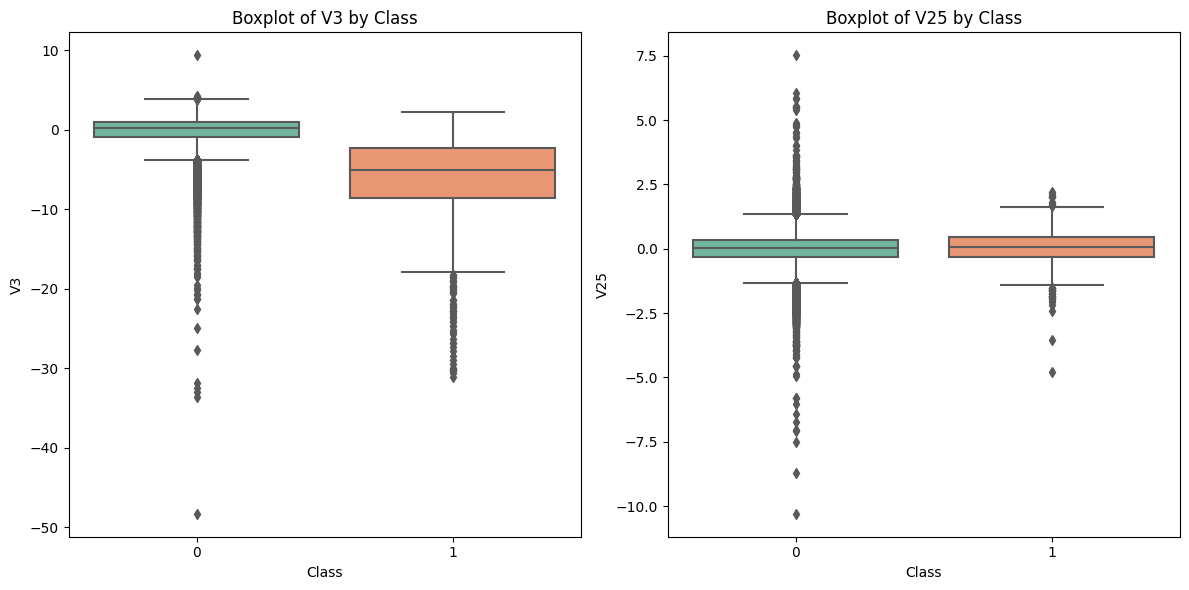

In [32]:
features_to_check = ['V3', 'V25'] # features I found to have extreme values in previous section

plt.figure(figsize=(12,6))
for i, feature in enumerate(features_to_check, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x='Class', y=feature, data=df, palette="Set2")
    plt.title(f"Boxplot of {feature} by Class")
plt.tight_layout()
plt.show()

***
## Feature Engineering
- Time-based features: Extract hour, day, time-since-last-transaction features
- Amount-based features: Log transforms, scaling, statistical ratio
- ask ai if this is possible as no column names

***
## Train-Test Split & Data Scaling

***
## Class Imbalance Treatment Strategies
- Baseline approach: Train on original imbalanced data
- SMOTE oversampling: Generate synthetic minority class samples
- Class weight adjustment: Use built-in class weighting in algorithms
- Strategy comparison: Compare distributions after each approach
- Strategy selection: Choose best approach based on validation performance

***
## Supervised Learning Models
- Baseline logistic regression (with class weights)
- Random forest
- XGBoost
- Compare performances & find best model

***
## Unsupervised Learning Models (Anomaly Detection)
- Isolation forest
- Autoencoder
- Compare performances & find best model

***
## Model Evaluation
- Confusion matrices: Visualize true/false positives and negatives
- Classification reports: Precision, recall, F1-score for each model
- ROC curves and AUC: Model discrimination ability
- Precision-Recall curves: More appropriate for imbalanced data
- Feature importance analysis: Which features drive fraud detection (may not be possible with hidden column names)

***
## Hyperparamter tuning? (for top 2 models)
- grid search or randomized search
- not essential

***
## Deployment Considerations
- real-time flagging & monitoring
- can merge with next section

***
## Conclusion & Future Work 
- best model
- business impact quantification: Expected fraud prevention and cost savings
- limitations
- improvements e.g ensemble of best models, hyperparamter tuning (if not implemented), API deploym